In [1]:
# Libraries for Scientific Computing
import numpy as np
import pyquaternion as pyQ

# Libraries for graphics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import juggle_axes

import scipy as sp
import scipy.integrate

In [2]:
def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return np.array([w, x, y, z])

def q_conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

# # Álgebra de quaternions:

def rotate(q, v):
    q = normalize(q)
    vec = np.concatenate(([0.0], v))
    return q_mult(q_mult(q, vec), q_conjugate(q))[1:]

def normalize(q, tolerance=1e-5):
    magnitude2 = sum(x * x for x in q)

    if abs(magnitude2 - 1.0) > tolerance:
        magnitude = np.sqrt(magnitude2)
        q = np.array([x / magnitude for x in q])

    return q

def ax2quaternion(v, theta):
    q = [0]*4
    v = normalize(v)
    q[0] = np.cos(theta/2.0)

    q[1] = v[0] * np.sin(theta/2.0)
    q[2] = v[1] * np.sin(theta/2.0)
    q[3] = v[2] * np.sin(theta/2.0)
    return q

### Mechanics

In [3]:
## -------------------------Ok------------------------------------------------

##### Inertial Tensor
### Input:  r -> positions;
###         masses -> masses from the body;
### Output: I -> Matrix representing the Inertial Tensor
##### Gil Miranda - last revision 15/09/2019

def getInertialTensor(r, masses):
    I = np.zeros((3,3))
    for i in range(len(masses)):
        I[0][0] += masses[i]*(r[i][1]**2 + r[i][2]**2)
        I[1][1] += masses[i]*(r[i][0]**2 + r[i][2]**2)
        I[2][2] += masses[i]*(r[i][0]**2 + r[i][1]**2)
        
        I[0][1] -= masses[i]*(r[i][0])*(r[i][1])
        I[0][2] -= masses[i]*(r[i][0])*(r[i][2])
        I[1][2] -= masses[i]*(r[i][1])*(r[i][2])
    I[1][0] = I[0][1]
    I[2][0] = I[0][2]
    I[2][1] = I[1][2]
    
    return I

## ----------------------Rever este-----------------------------------------

##### Internal Angular Momentum
### Input:  Q -> ?;
###         v -> ?;
###         masses -> masses from the body;
### Output: s -> ?
##### Gil Miranda - last revision 15/09/2019

def getInternalAngularMomentum(Q, v, masses):
    s = np.zeros(3)
    for (i,m) in enumerate(masses):
        s = s + m*np.cross(Q[i], v[i])
    return s

## --------------------------Ok-------------------------------------

##### Center of Mass
### Input:  r -> position vector;
###         masses -> masses from the body;
### Output: cm -> vector for center of mass of the system
##### Gil Miranda - last revision 15/09/2019
def CM(r, masses):
    cm = np.zeros(3)
    for i in range(len(r)):
        cm[0] += masses[i] * r[i][0]
        cm[1] += masses[i] * r[i][1]
        cm[2] += masses[i] * r[i][2]
    total_m = sum(masses)
    cm *= (1/total_m)
    return cm

### Initial Values

In [4]:
## Ok

masses = np.array([1,1,1,1,1,1,1,1,.5,.5])
n_mass = len(masses)
r_0 = [None]*n_mass

r_0[0] = [1, 1, 0] # Center of the Body
r_0[1] = [1, -1, 0] # Back of the Body
r_0[2] = [-1, 1, 0] # Back Paw 1
r_0[3] = [-1, -1, 0] # Back Paw 2
r_0[4] = [1, 1, -1] # Tails
r_0[5] = [1,-1,-1]
r_0[6] = [-1,1,-1] # Front Body
r_0[7] = [-1, -1, -1] # Front Paw 1
r_0[8] = [0, -.5, .5] # Front Paw 2
r_0[9] = [0, .5, .5] # Head

r_0 = np.array(r_0)

#### Translation so we have $CM = (0,0,0)$

In [5]:
r_cm = CM(r_0, masses)
for i in range(len(r_0)):
    r_0[i] -= r_cm

### Visualizing the Cube

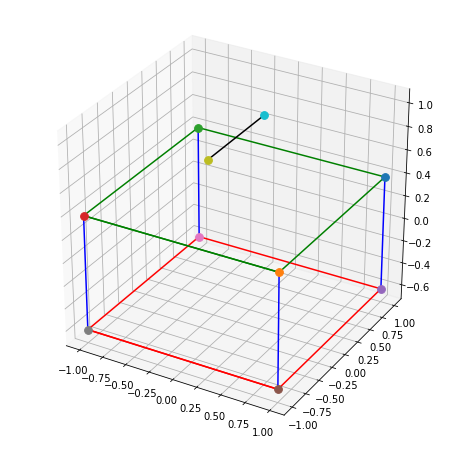

In [6]:

#Only used in animation
body_lines = [
    ## top
    (0, 1),
    (0, 2),
    (1, 3),
    (3, 2),

    ## bottom
    (4, 5),
    (4, 6),
    (5, 7),
    (7, 6),
    
    ## vertical
    (0, 4),
    (1, 5),
    (3, 7),
    (2, 6),
    
    ## propeller
    (8, 9)
]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
ani_lines = [ax.plot([], [], [], 'k-')[0] for _ in body_lines]

#for line, (sp, ep) in zip(ani_lines, body_lines):
#    line._verts3d = positions[[sp,ep], :, num].T.tolist()

## Base of the cube
ax.plot([-1,1],[-1,-1],[-0.61111111,-0.61111111], color = 'r')
ax.plot([1,1],[-1,1],[-0.61111111,-0.61111111], color = 'r')
ax.plot([-1,1],[-1,-1],[-0.61111111,-0.61111111], color = 'r')
ax.plot([1,-1],[1,1],[-0.61111111,-0.61111111], color = 'r')
ax.plot([-1,-1],[-1,1],[-0.61111111,-0.61111111], color = 'r')

## Top of the cube
ax.plot([-1,1],[-1,-1],[0.38888889,0.38888889], color = 'g')
ax.plot([1,1],[-1,1],[0.38888889,0.38888889], color = 'g')
ax.plot([-1,1],[-1,-1],[0.38888889,0.38888889], color = 'g')
ax.plot([1,-1],[1,1],[0.38888889,0.38888889], color = 'g')
ax.plot([-1,-1],[-1,1],[0.38888889,0.38888889], color = 'g')

## Vertical Lines
ax.plot([-1,-1],[-1,-1],[0.38888889,-0.61111111], color = 'b')
ax.plot([-1,-1],[1,1],[0.38888889,-0.61111111], color = 'b')
ax.plot([1,1],[1,1],[0.38888889,-0.61111111], color = 'b')
ax.plot([1,1],[-1,-1],[0.38888889,-0.61111111], color = 'b')

## helice
ax.plot([0,0],[-.5,.5],[0.88888889,0.88888889], color = 'black')


for i,r in enumerate(r_0):
    ax.scatter3D(r[0], r[1], r[2], label = i, s = 60)
plt.show()

#### Motion

In [46]:
## Identity Rotation
q_0 = [1,0,0,0]
p_0 = [0,0,5]

tmax = 10
num_times = 400
time = np.linspace(0,tmax,num_times)
r = [0 for i in range(0, len(masses))]

## wth is going on here?
for i in range(0,len(masses)):
    r[i] = lambda t, i=i: r_0[i, :]

    
tmax_r1 = tmax/20
ang_max = np.pi/2
freq = 2*np.pi/tmax
for i in range(len(masses)-2):
    def ri(t, j=i):
        return rotate( ax2quaternion(np.array([0,0,1]), freq*t/tmax_r1), r_0[j, :] )
        #if t < tmax_r1:
            #return rotate( ax2quaternion(np.array([1,0,0]), ang_max), r_0[j, :] )
        #else:
            #rx = rotate( ax2quaternion(np.array([0,0,1]), ang_max), r_0[j, :] )
            #axis = rotate( ax2quaternion(np.array([0,0,1]), ang_max), r_0[1, :] ) -  rotate( ax2quaternion(np.array([1,0,0]), ang_max), r_0[0, :] )

            #return rotate( ax2quaternion( axis, freq*(t - tmax_r1)), rx)?
    r[i] = ri
    
for i in (8,9):
    def ri(t, j=i):
        return rotate( ax2quaternion(np.array([0,0,1]), -freq*t), r_0[j, :] )
        #if t < tmax_r1:
            #return rotate( ax2quaternion(np.array([1,0,0]), ang_max), r_0[j, :] )
        #else:
            #rx = rotate( ax2quaternion(np.array([0,0,1]), ang_max), r_0[j, :] )
            #axis = rotate( ax2quaternion(np.array([0,0,1]), ang_max), r_0[1, :] ) -  rotate( ax2quaternion(np.array([1,0,0]), ang_max), r_0[0, :] )

            #return rotate( ax2quaternion( axis, freq*(t - tmax_r1)), rx)?
    r[i] = ri
    
def particles(t):
    a = np.zeros([len(masses), 3])
    for i in range(len(masses)):
        a[i] = r[i](t)
    return a

def eqOfMotion(x, t):
    # q -> quaternion for rotation
    # p -> body angular momentum
    q = np.array(x[:4])
    p = np.array(x[4:])
    # Position
    pos = particles(t)
    
    #Velocities
    ep = 1e-7
    v = (particles(t+ep) - particles(t-ep))/(2*ep)
    
    # Tensor of Inertia
    I = getInertialTensor(pos, masses)
    Iinv = np.linalg.inv(I)
    
    # Angular Momentum
    L = getInternalAngularMomentum(pos, v, masses)
    dumb = np.dot(Iinv, (p-L))
    dp_dt = np.cross(p,dumb)
    
    omega = np.dot(Iinv, (p-L))
    omega = np.concatenate(([0.], omega))
    dq_dt = 0.5 * q_mult(q, omega)
    return [dq_dt[0], dq_dt[1], dq_dt[2], dq_dt[3]] + [dp_dt[0], dp_dt[1], dp_dt[2]]

In [47]:
args = (getInertialTensor,getInternalAngularMomentum)
q = sp.integrate.odeint(eqOfMotion,q_0+p_0,time)
q = np.transpose(q)
q = q[:4,:]

In [48]:
positions = np.empty([len(masses), 3, num_times])

for k, rot in enumerate(np.transpose(q)):
    t = k*tmax/num_times
    p = particles(t)
    for i in range(0, len(masses)):
        positions[i, : ,k] = rotate(rot, p[i, :])

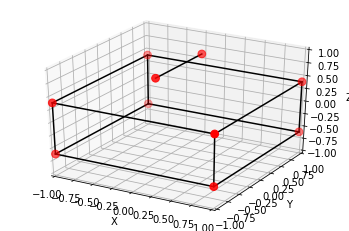

In [49]:
def update_plot(num, positions, body_lines, ani_lines, sc):
    t = tmax*num/num_times
    for line, (sp, ep) in zip(ani_lines, body_lines):
        line._verts3d = positions[[sp,ep], :, num].T.tolist()
    sc._offsets3d = juggle_axes(positions[:,0, num], positions[:,1, num], positions[:,2, num], 'z')
    return sc


#Create figure object and set animation
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim3d([-1.0, 1.0])
ax.set_ylim3d([-1.0, 1.0])
ax.set_zlim3d([-1.0, 1.0])
#ax.grid()


# Lines between parts of cat

ani_lines = [ax.plot([], [], [], 'k-')[0] for _ in body_lines]


sc = ax.scatter3D(positions[:,0, 0], positions[:,1, 0], positions[:,2, 0], marker='o', c='red', s = 60)
#for sp, ep in body_lines:
#    ax.plot(positions[sp:ep, 0, 0], positions[sp:ep, 1, 0], positions[sp:ep, 2, 0])


ani = FuncAnimation(fig, update_plot,  frames=len(time), interval=2,
        fargs=(positions, body_lines, ani_lines, sc), repeat=True)
plt.show()
ani.save('./cube.gif', writer='pillow', fps=15)

In [29]:
#Only used in animation
body_lines = [
    ## top
    (0, 1),
    (0, 2),
    (1, 3),
    (3, 2),

    ## bottom
    (4, 5),
    (4, 6),
    (5, 7),
    (7, 6),
    
    ## vertical
    (0, 4),
    (1, 5),
    (3, 7),
    (2, 6),
    
    ## propeller
    (8, 9)
]
